In [10]:
import torch as t 
import torch.nn as nn

class Autoencoder(nn.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(self, input_size: int, hidden_size: int, latent_dim_size: int = 5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_dim_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed


def generate_random_data(input_size: int, batch_size: int) -> t.Tensor:
    return t.rand(batch_size, input_size)



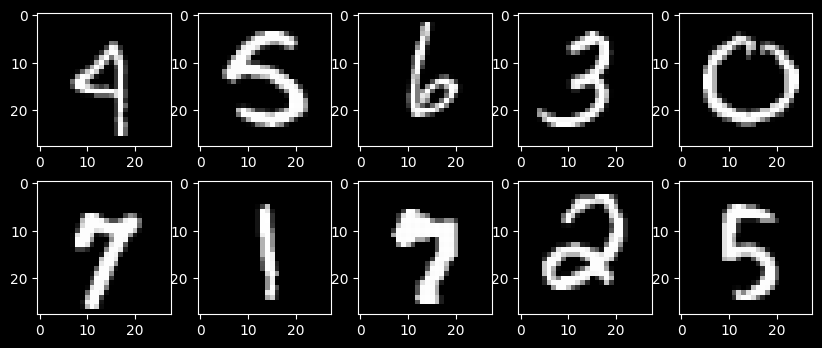

In [11]:
# load l2 loss
criterion = nn.MSELoss()

# load mnist data with torch vision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = MNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# visualize data
import matplotlib.pyplot as plt
import numpy as np

def show_images(images: t.Tensor):
    images = images.reshape(-1, 28, 28)
    images = images.detach().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
    plt.show()

images, labels = next(iter(train_loader))
show_images(images)

In [12]:
images.shape

torch.Size([64, 1, 28, 28])

In [ ]:
# load autoencoder
autoencoder = Autoencoder(input_size=28*28, hidden_size=100, latent_dim_size=5)

# load optimizer
optimizer = t.optim.Adam(autoencoder.parameters(), lr=1e-3)

# train
def train(autoencoder: nn.Module, train_loader: DataLoader, optimizer: t.optim.Optimizer, criterion: nn.Module, epochs: int = 10):
    for epoch in range(epochs):
        for images, _ in train_loader:
            images = images.reshape(-1, 28*28)
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    
    print('Finished Training')
    
train(autoencoder, train_loader, optimizer, criterion, epochs=10)

# test
def test(autoencoder: nn.Module, test_loader: DataLoader, criterion: nn.Module):
    with t.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, 28*28)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            # print(f'Loss: {loss.item():.4f}')
    
    print('Finished Testing')

test(autoencoder, test_loader, criterion)

# visualize reconstructed images
with t.no_grad():
    for images, _ in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = autoencoder(images)
        break

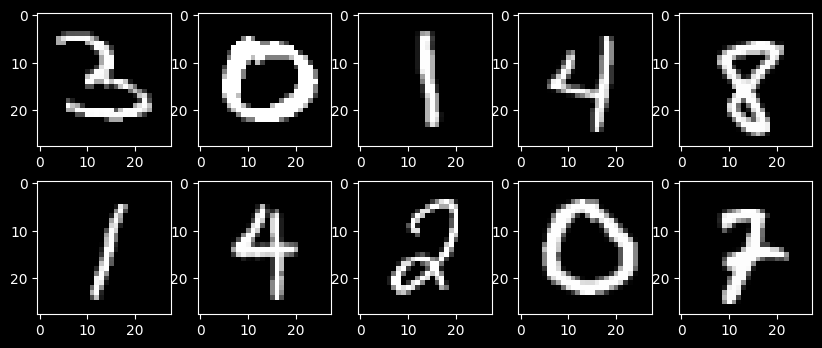

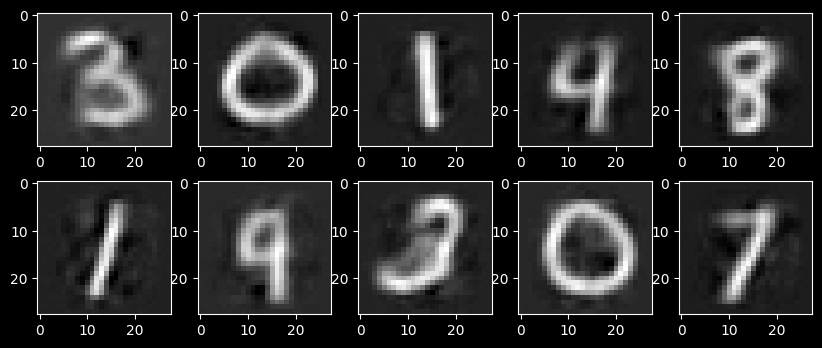

In [15]:

show_images(images)

show_images(outputs)

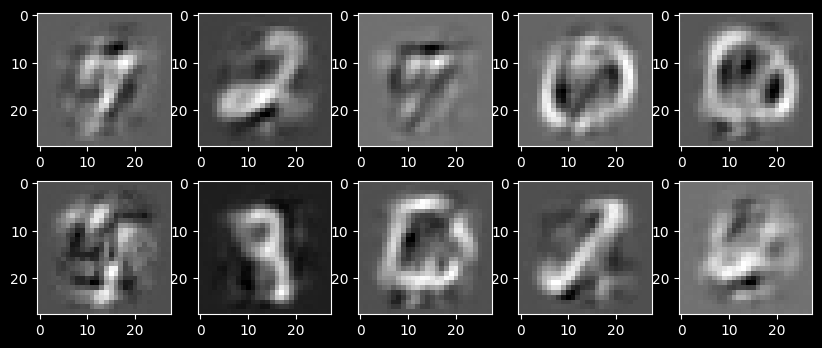

In [35]:
latent_space_samples = autoencoder.decoder(t.randn(10, 5)).reshape(-1, 28, 28)
show_images(latent_space_samples)

In [ ]:
# write a convolutional autoencoder
# Your encoder should consist of two convolutional layers, a flatten, then two linear layers. After each convolution or linear layer (except for the last one) you should have an activation function. The convolutions should have kernel size 4, stride 2, padding 0 (recall from yesterday that this exactly halves the width and height). The number of output channels can be 16 and 32 respectively.
from torch.nn import Conv2d, Flatten, Linear, ConvTranspose2d, ReLU, Unflatten
class ConvolutionalAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            Flatten(),
            Linear(32*7*7, 100),
            Linear(100, 5)
        )
        self.decoder = nn.Sequential(
            Linear(5, 100),
            Linear(100, 32*7*7),
            nn.ReLU(),
            Unflatten(1, (32, 7, 7)),
            ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed

convolutional_autoencoder = ConvolutionalAutoencoder()

# load optimizer
optimizer = t.optim.Adam(convolutional_autoencoder.parameters(), lr=1e-3)

# train
def train(autoencoder: nn.Module, train_loader: DataLoader, optimizer: t.optim.Optimizer, criterion: nn.Module, epochs: int = 3):
    for epoch in range(epochs):
        for images, _ in train_loader:
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    
    print('Finished Training')
    
train(convolutional_autoencoder, train_loader, optimizer, criterion, epochs=4)
# test

def test(autoencoder: nn.Module, test_loader: DataLoader, criterion: nn.Module):
    with t.no_grad():
        for images, _ in test_loader:
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            # print(f'Loss: {loss.item():.4f}')
    
    print('Finished Testing')

test(convolutional_autoencoder, test_loader, criterion)

# visualize reconstructed images
with t.no_grad():
    for images, _ in test_loader:
        outputs = convolutional_autoencoder(images)
        break

show_images(images)
show_images(outputs)

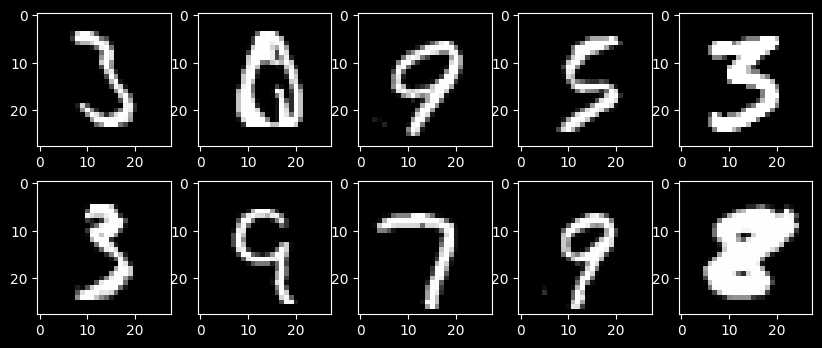

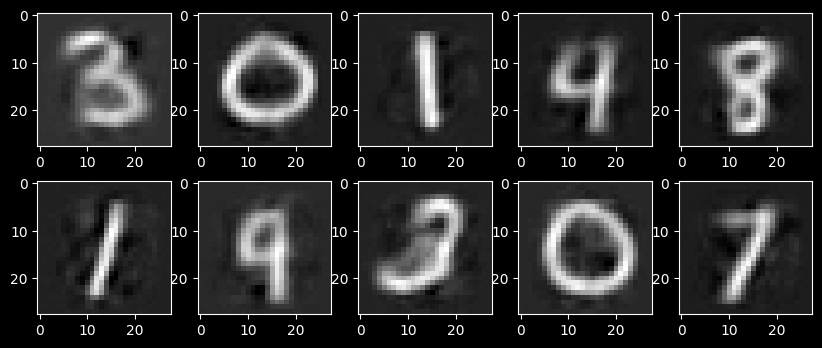

In [51]:
show_images(images)
show_images(outputs)

In [58]:
import plotly.express as px
from einops import rearrange

device = "cpu"
latent_dim_size = 5
model = convolutional_autoencoder

# Choose number of interpolation points, and interpolation range (you might need to adjust these)
n_points = 11
interpolation_range = (-10, 10)

# Constructing latent dim data by making two of the dimensions vary independently between 0 and 1
latent_dim_data = t.zeros((n_points, n_points, latent_dim_size), device=device)
x = t.linspace(*interpolation_range, n_points)
latent_dim_data[:, :, 1] = x.unsqueeze(0)
latent_dim_data[:, :, 0] = x.unsqueeze(1)
# Rearranging so we have a single batch dimension
latent_dim_data = rearrange(latent_dim_data, "b1 b2 latent_dim -> (b1 b2) latent_dim")

# Getting model output, and normalising & truncating it in the range [0, 1]
output = model.decoder(latent_dim_data).detach().cpu().numpy()
output_truncated = np.clip((output * 0.3081) + 0.1307, 0, 1)
output_single_image = rearrange(output_truncated, "(b1 b2) 1 height width -> (b1 height) (b2 width)", b1=n_points)

# Plotting results
fig = px.imshow(output_single_image, color_continuous_scale="greys_r")
fig.update_layout(
    title_text="Decoder output from varying first two latent space dims", title_x=0.5,
    coloraxis_showscale=False, 
    xaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x]),
    yaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x])
)
fig.show()

In [72]:
# let's plot the embeddings of the training data in plotly

import plotly.express as px
from einops import rearrange

device = "cpu"
latent_dim_size = 5
model = convolutional_autoencoder

test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# for each data point, generate their latent space representation
latent_space_data = []
true_label = []
for images, label in test_loader:
    latent_space_data.append(model.encoder(images).detach().cpu().numpy())
    true_label.append(label.detach().cpu().numpy())
    
latent_space_data = np.concatenate(latent_space_data, axis=0)
true_label = np.concatenate(true_label, axis=0, dtype=np.int)
true_label_string = [str(i) for i in true_label]

# plot the latent space data
fig = px.scatter(x=latent_space_data.T[0], y=latent_space_data.T[1], color=true_label_string)
fig.show()

/var/folders/qd/04zj2h4n2pvc87x_7w1z97_r0000gn/T/ipykernel_5783/432022654.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [73]:
# let's convert the latent space to a 2D space using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
latent_space_data_2d = tsne.fit_transform(latent_space_data)

# plot the latent space data
fig = px.scatter(x=latent_space_data_2d.T[0], y=latent_space_data_2d.T[1], color=true_label_string)

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [75]:
fig.show()

# Sampling from our autoencoder model

In [11]:
# load 
import torch 
from VAE_implementation.models import VAE
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
batch_size = 64
latent_dim_size = 5

train_data = MNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = VAE(latent_dim_size=latent_dim_size)
model.load_state_dict(torch.load("mnist_autoencoder.pth"))

<All keys matched successfully>

In [13]:
import plotly.express as px
from einops import rearrange
import torch as t
import numpy as np

device = "cpu"
latent_dim_size = 5
model = model


def plot_output_in_latent_space(model, device):
    '''
    Model should have a decoder method.
    '''
    # Choose number of interpolation points, and interpolation range (you might need to adjust these)
    n_points = 11
    interpolation_range = (-10, 10)

    # Constructing latent dim data by making two of the dimensions vary independently between 0 and 1
    latent_dim_data = t.zeros((n_points, n_points, model.latent_dim_size), device=device)
    x = t.linspace(*interpolation_range, n_points)
    latent_dim_data[:, :, 0] = x.unsqueeze(0)
    latent_dim_data[:, :, 1] = x.unsqueeze(1)
    # Rearranging so we have a single batch dimension
    latent_dim_data = rearrange(latent_dim_data, "b1 b2 latent_dim -> (b1 b2) latent_dim")

    # Getting model output, and normalising & truncating it in the range [0, 1]
    output = model.decoder(latent_dim_data).detach().cpu().numpy()
    output_truncated = np.clip((output * 0.3081) + 0.1307, 0, 1)
    output_single_image = rearrange(output_truncated, "(b1 b2) 1 height width -> (b1 height) (b2 width)", b1=n_points)

    # Plotting results
    fig = px.imshow(output_single_image, color_continuous_scale="greys_r")
    fig.update_layout(
        title_text="Decoder output from varying first two latent space dims", title_x=0.5,
        coloraxis_showscale=False, 
        xaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x]),
        yaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x])
    )
    return fig

plot_output_in_latent_space(model, device).show()

In [15]:
# let's plot the embeddings of the training data in plotly

import plotly.express as px
from einops import rearrange

device = "cpu"
latent_dim_size = 5
model = model

test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

def plot_test_data_in_latent_space(model, test_loader, device):
    ''' 
    Model should have an encoder method.
    '''

    # for each data point, generate their latent space representation
    latent_space_data = []
    true_label = []
    for images, label in test_loader:
        latent_space_data.append(model.encoder(images).detach().cpu().numpy())
        true_label.append(label.detach().cpu().numpy())
        
    latent_space_data = np.concatenate(latent_space_data, axis=0)
    true_label = np.concatenate(true_label, axis=0, dtype=np.int)
    true_label_string = [str(i) for i in true_label]

    # plot the latent space data
    fig = px.scatter(x=latent_space_data.T[0], y=latent_space_data.T[1], color=true_label_string)
    return fig

plot_test_data_in_latent_space(model, test_loader, device).show()

AttributeError: 'VAE' object has no attribute 'encoder'